***
# Exemplary Dark Matter Data Release
***

Today many experiments search for dark matter particles with low detection thresholds. To enhance the efficient use of the measured data for the calculation of exclusion limits, an open data policy is desirable. In this notebook, we show on mock data how the data formats of a release could be chosen, and summarize some useful information about the joint analysis of data from multiple experiments.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.stats import expon, norm, uniform, gamma
from scipy import stats
from itertools import product
import numba as nb
from scipy.optimize import fsolve, bisect, minimize
from PIL import Image, ImageDraw
import matplotlib as mpl
from tqdm.auto import tqdm, trange
%config InlineBackend.figure_formats = ['svg']

In [4]:
fontsize = 12

mpl.rcParams['xtick.labelsize'] = fontsize
mpl.rcParams['ytick.labelsize'] = fontsize
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['legend.fontsize'] = fontsize
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

## Get Data

We simulate three mock experiments A, B and C (for uniqueness we will sometimes call them Alice, Bob and Carol). All of them have share the same parametrization of an expected signal model, depending on a paramter $\lambda$. The experiments have individual backgrounds and measurement characteristics, summarized below.

**Measurement Characteristics:**

|                             | Experiment A  |  Experiment B  |  Experiment C  |
|-----------------------------|---------------|----------------|----------------|
| *Exposure* $(kg \cdot d)$   | 7 | 5 | 100 |
| *Rate* $( 1 / (kg \cdot d))$|  300 |   200 |   20 |
| *Counts after Cuts* |  2100 |   1000 |   2000 |
| *Lower Threshold* $(keV)$   |  0.1 |   0.035 |   1 |
| *Upper Threshold* $(keV)$   |  20 |   10 |  400 |
| *Resolution* $(keV)$         |  0.015 |   0.005 |  0.150 |
| *Efficiency above Threshold* |  0.8 |   0.65 |  0.5 |

**Signal models:**

The common signal model $\mathcal{S}$ is:

$$ \mathcal{S}_A(x | \lambda, \omega) = \mathcal{S}_B(x | \lambda, \omega) = \mathcal{S}_C(x | \lambda, \omega) = \omega \cdot \mathcal{Exp}(x | \lambda) $$

... where $x$ is the recoil energy, $\lambda$ a parameter of the dark matter model, $\omega$ is the dark matter cross section with the detector material and $\mathcal{Exp}$ is an exponential distribution.

**Background models:**

The individual background models $\mathcal{B}$ are:

$$ \mathcal{B}_A(x) = 0.4 \cdot \mathcal{U}(x) + 0.3 \cdot \mathcal{N}(x|6,0.5) + 0.3 \cdot \mathcal{E}(x|0.3)$$

$$ \mathcal{B}_B(x) = 0.35 \cdot \mathcal{U}(x) + 0.3 \cdot \mathcal{N}(x|6,0.5) + 0.35 \cdot \mathcal{E}(x|0.1)$$

$$ \mathcal{B}_C(x) = 0.5 \cdot \mathcal{\Gamma}(x|0.375, 933.33) + \sum_i w_i \cdot \mathcal{N}(x|\mu_i,\sigma_i)$$

... with $w = (0.08, 0.12, 0.05, 0.15, 0.1)$, $\mu = (45, 75, 120, 200, 300)$ and $\sigma = (2, 3, 5, 10, 20)$.

In [15]:
NAMES = ['A', 'B', 'C']
EXPOSURE = np.array([7, 5, 100])
COUNTS = np.array([2100, 1000, 2000])
THRESHOLD_LOW = np.array([0.1, 0.035, 1])
THRESHOLD_UP = np.array([20, 10, 400])
RESOLUTION = np.array([0.015, 0.005, 0.15])
EFFICIENCY = np.array([0.8, 0.65, 0.5])
NMBR_REPETITIONS = 10

ALICE_LAMBDA = 0.3

Calc the normalization constants.

$\int_{\Omega} B_A(x) dx = \frac{2100 \text{Counts}}{7 \text{kg day}} = 300 \frac{\text{Counts}}{\text{kg day}}$

$\int_{\Omega} B_B(x) dx = \frac{1000 \text{Counts}}{5 \text{kg day}} = 200 \frac{\text{Counts}}{\text{kg day}}$

Likelihood fit ends up with normalization 2100 and 1000 (number events).

Therefore division by exposure should give desired normalization.

True value of signal prefactor is 0.3 * nmbr events / exposure = 100 for A and 0.35 * nmbr events / exposure = 70 for B.

We define several functions to sample the data of our mock experiments.

In [16]:
def sample_in_region(distribution: object, 
                     upper: float,
                     lower: float,
                     size: int):
    """
    Returns a sample of given size from a distribution, truncated to a certain region of values.
    
    :param distribution: An object which takes only one required, integer argument: size. This is the desired sample size.
    :type distribution: object
    :param upper: The upper truncation limit for the distribution.
    :type upper: float
    :param lower: The lower truncation limit for the distribution.
    :type lower: float
    :param size: The desired sample size.
    :type size: int
    :return: The sample from the distribution.
    :rtype: np.array
    """
    retval = np.zeros(size)
    while True:
        cond = np.logical_or(retval < lower, retval > upper)
        if any(cond):
            retval[cond] = distribution(size=np.sum(cond))
        else:
            return retval

In [17]:
def bck_alice(size:int): 
    """
    The distribution object for the background model of experiment A.
    
    :param size: The desired sample size.
    :type size: int
    :return: The sample from the background model.
    :rtype: np.array
    """
    retval = np.empty(size, dtype=float)
    randvals = np.random.uniform(size=size)
    retval[randvals < 0.4] = np.random.uniform(THRESHOLD_LOW[0],THRESHOLD_UP[0],size=np.sum(randvals < 0.4)) # flat bck
    retval[np.logical_and(randvals >= 0.4, randvals < 0.7)] = np.random.normal(6,0.5,size=np.sum(np.logical_and(randvals >= 0.4, randvals < 0.7))) # peaks
    retval[randvals >= 0.7] = np.random.exponential(ALICE_LAMBDA,size=np.sum(randvals >= 0.7))
    retval += np.random.normal(0,RESOLUTION[0],size=size) # resolution
    return retval

def bck_bob(size:int): 
    """
    The distribution object for the background model of experiment B.
    
    :param size: The desired sample size.
    :type size: int
    :return: The sample from the background model.
    :rtype: np.array
    """
    retval = np.empty(size, dtype=float)
    randvals = np.random.uniform(size=size)
    retval[randvals < 0.35] = np.random.uniform(THRESHOLD_LOW[1],THRESHOLD_UP[1],size=np.sum(randvals < 0.35)) # flat bck
    retval[np.logical_and(randvals >= 0.35, randvals < 0.65)] = np.random.normal(6,0.5,size=np.sum(np.logical_and(randvals >= 0.35, randvals < 0.65))) # peaks
    retval[randvals >= 0.65] = np.random.exponential(0.1,size=np.sum(randvals >= 0.65))
    retval += np.random.normal(0,RESOLUTION[1],size=size) # resolution
    return retval

def bck_carol(size:int): 
    """
    The distribution object for the background model of experiment C.
    
    :param size: The desired sample size.
    :type size: int
    :return: The sample from the background model.
    :rtype: np.array
    """
    retval = np.empty(size, dtype=float)
    randvals = np.random.uniform(size=size)
    retval[randvals < 0.5] = np.random.gamma(2.25,66.67,size=np.sum(randvals < 0.5)) # flat bck
    w = [0, 0 + 0.08, 0 + 0.08 + 0.12, 0 + 0.08 + 0.12 + 0.05, 
         0 + 0.08 + 0.12 + 0.05 + 0.15, 0 + 0.08 + 0.12 + 0.05 + 0.15 + 0.1]
    mu = [45, 75, 120, 200, 300]
    sigma = [2, 3, 5, 10, 15]
    for i in range(5):
        retval[np.logical_and(randvals >= 0.5 + w[i], randvals < 0.5 + w[i+1])] = np.random.normal(loc=mu[i],scale=sigma[i],size=np.sum(np.logical_and(randvals >= 0.5 + w[i], randvals < 0.5 + w[i+1]))) # peaks
    retval += np.random.normal(0,RESOLUTION[2],size=size) # resolution
    return retval

With the above defined functions, we are ready to sample the background data of our three experiments. Because we are in the merry position that we can sample as much statistics as we want, we repeat the sampling a certain number of times. With the redundant data sets, we will calculate confidence levels for the exclusion limits later.

In [18]:
data_alice = [sample_in_region(bck_alice, lower=THRESHOLD_LOW[0], upper=THRESHOLD_UP[0], size=COUNTS[0]) for i in range(NMBR_REPETITIONS)]
data_bob = [sample_in_region(bck_bob, lower=THRESHOLD_LOW[1], upper=THRESHOLD_UP[1], size=COUNTS[1]) for i in range(NMBR_REPETITIONS)]
data_carol = [sample_in_region(bck_carol, lower=THRESHOLD_LOW[2], upper=THRESHOLD_UP[2], size=COUNTS[2]) for i in range(NMBR_REPETITIONS)]

Lets have a look at the energy spectra of our experiments.

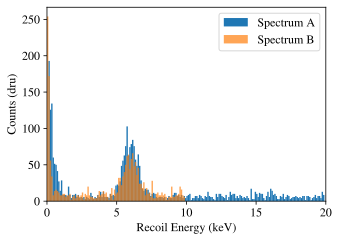

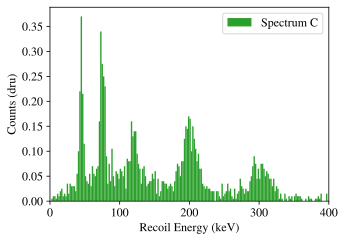

In [19]:
mpl.rcParams['figure.figsize'] = (5, 3.5)

bin_width = 0.1
ran = (0,20)
bins = np.arange(ran[0],ran[1],bin_width)

plt.hist(data_alice[0], bins=bins, weights=1/bin_width/EXPOSURE[0]*np.ones(len(data_alice[0])), alpha=1, label='Spectrum A', range=ran)
plt.hist(data_bob[0], bins=bins, weights=1/bin_width/EXPOSURE[1]*np.ones(len(data_bob[0])), alpha=0.7, label='Spectrum B', range=ran)
plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Counts (dru)')
plt.xlim(ran)
plt.legend()
plt.show()

bin_width = 2
ran = (0,400)
bins = np.arange(ran[0],ran[1],bin_width)

plt.hist(data_carol[0], bins=bins, weights=1/bin_width/EXPOSURE[2]*np.ones(len(data_carol[0])), alpha=1, label='Spectrum C', range=ran, color='C2')
plt.xlabel('Recoil Energy (keV)')
plt.ylabel('Counts (dru)')
plt.xlim(ran)
plt.legend()
plt.show()

We assume, that no energy dependent cuts or event rejection effects (like pile-up) were present in the process of data collection and analysis. In this case, we can create our cut efficiencies from a simple model, which depends only on the detector resolution, the threshold and the constant survival probability above threshold.

In [20]:
def threshold_model(x, a0, a1, a2):
    """
    Fit model for the threshold.

    :param x: The grid on which the model is evaluated.
    :type x: array
    :param a0: Estimated constant survival probability above threshold.
    :type a0: float
    :param a1: Estimated threshold value.
    :type a1: float
    :param a2: Estimator for the energy resolution.
    :type a2: float
    :return: The evaluated error function
    :rtype: array
    """
    return 0.5 * a0 * (1 + erf((x - a1) / (np.sqrt(2) * a2)))

In [21]:
grids = np.array([np.arange(0, THRESHOLD_UP[i], THRESHOLD_UP[i]/15000) for i in range(3)])
efficiencies = np.array([threshold_model(grids[i],
                           a0=EFFICIENCY[i],
                           a1=THRESHOLD_LOW[i],
                           a2=RESOLUTION[i]) for i in range(3)])

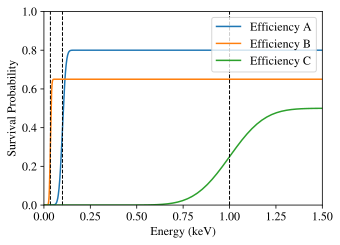

In [22]:
mpl.rcParams['figure.figsize'] = (5, 3.5)

for grid, eff, tv, lab in zip(grids, efficiencies, THRESHOLD_LOW, NAMES):
    plt.plot(grid, eff, label='Efficiency ' + lab)
    plt.axvline(x=tv, color='black', linewidth=1, linestyle='dashed')
plt.xlabel('Energy (keV)')
plt.ylabel('Survival Probability')
plt.xlim(0,1.5)
plt.ylim(0,1)
plt.legend(loc='upper right')
plt.show()

The cut efficiencies can be used to re-weight the bins of the energy spectra and reconstruct the estimated event rate in DRU.

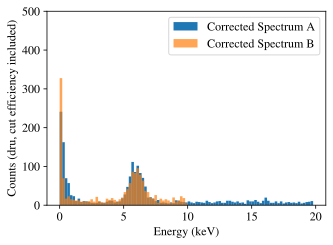

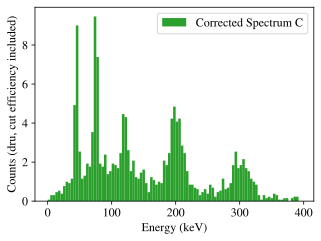

In [23]:
mpl.rcParams['figure.figsize'] = (5, 3.5)

bin_width = 0.2
ran = (0,20)
bins = np.arange(ran[0],ran[1],bin_width)

for i, (data, name) in enumerate(zip([data_alice[0], data_bob[0]], NAMES[:2])):
    
    hist, bins = np.histogram(data, bins=bins, range=(THRESHOLD_LOW[i], THRESHOLD_UP[i]))
    bins_center = bins[:-1] + (bins[1:] - bins[:-1])/2
    hist = hist / np.interp(bins_center, grids[i], efficiencies[i])
    plt.hist(bins_center, bins, weights=hist/EXPOSURE[i]/bin_width, label='Corrected Spectrum ' + name, alpha=1-0.3*i)

plt.ylim(0,500)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts (dru, cut efficiency included)')
plt.legend()
plt.show()

bin_width = 4
ran = (0,400)
bins = np.arange(ran[0],ran[1],bin_width)

hist, bins = np.histogram(data_carol[0], bins=bins, range=(THRESHOLD_LOW[i], THRESHOLD_UP[i]))
bins_center = bins[:-1] + (bins[1:] - bins[:-1])/2
hist = hist / np.interp(bins_center, grids[i], efficiencies[i])
plt.hist(bins_center, bins, weights=hist/EXPOSURE[i]/bin_width, label='Corrected Spectrum ' + NAMES[2], color='C2')

plt.xlabel('Energy (keV)')
plt.ylabel('Counts (dru, cut efficiency included)')
plt.legend()
plt.show()

## Export the data

We export the data sets in a suitable data format. This format is especially independent of any specific software tools and can therefore be processed by anyone.

In [24]:
for i in range(NMBR_REPETITIONS):
    np.savetxt('data/alice/data_alice_{}.txt'.format(i), np.column_stack([data_alice[i]]))
    np.savetxt('data/bob/data_bob_{}.txt'.format(i), np.column_stack([data_bob[i]]))
    np.savetxt('data/carol/data_carol_{}.txt'.format(i), np.column_stack([data_carol[i]]))

In [25]:
np.savetxt('data/alice/efficiency_alice.txt', np.column_stack([grids[0], efficiencies[0]]))
np.savetxt('data/bob/efficiency_bob.txt', np.column_stack([grids[1], efficiencies[1]]))
np.savetxt('data/carol/efficiency_carol.txt', np.column_stack([grids[2], efficiencies[2]]))

## Trigger efficiency effects

When comparing energy spectra of different experiments, one has to take care of a curious effect. Assume, two experiments observe the same signal. The efficiency correction of the histogram is needed to create comparable count rates. However, the efficiency is typically stated w.r.t. a simulated, true energy, while the energy spectrum is stated w.r.t. the measured energy. This corresponds to a convolution effect on the energy spectrum, and produces a virtual blow-up of the spectrum close to the energy threshold. The effect is visualized below.

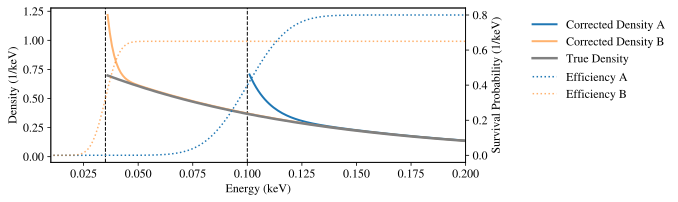

In [26]:
mpl.rcParams['figure.figsize'] = (10, 3)

bin_width = 0.001
ran = (0.01,0.2)
bins = np.arange(ran[0],2*ran[1],bin_width)

grid_data = [bins[np.logical_and(bins > THRESHOLD_LOW[i], bins < THRESHOLD_UP[i])] for i in range(2)]

mock = []
mock_true = []
for i in range(2):
    temp = np.exp(-bins/0.1)
    kernel = norm.pdf(np.arange(-3*RESOLUTION[i], 3*RESOLUTION[i], bin_width), loc=0, scale=RESOLUTION[i])
    kernel /= np.sum(kernel)
    lek = len(kernel)
    let = len(temp)
    if lek > let:
        kernel = kernel[int((lek - let)/2):-int((lek - let)/2)]
    mock_true.append(temp[np.logical_and(bins > THRESHOLD_LOW[i], bins < THRESHOLD_UP[i])])
    mock.append(np.convolve(a=temp, v=kernel, mode='same')[np.logical_and(bins > THRESHOLD_LOW[i], bins < THRESHOLD_UP[i])])

fig, host = plt.subplots()
par1 = host.twinx()

host.set_xlabel('Energy (keV)')
host.set_ylabel('Density (1/keV)')
par1.set_ylabel('Survival Probability (1/keV)')

color1 = 'black'
color2 = 'black'

linestyles = ['dotted', 'dashed']

for i in range(2):
    
    denum = np.interp(grid_data[i], grids[i], efficiencies[i])
    _ = host.plot(grid_data[i], mock[i]/denum*EFFICIENCY[i], label='Corrected Density ' + NAMES[i], color='C'+str(i), linewidth=2, alpha=1-0.4*i)
    if i == 1:
        _ = host.plot(grid_data[i], mock_true[i], color='grey', linewidth=2.5, linestyle='solid', alpha=1, label='True Density')
    
    _ = par1.plot(grids[i], efficiencies[i], label='Efficiency ' + NAMES[i], 
              color='C'+str(i), alpha=1-0.4*i, linestyle='dotted') #  linestyles[i])
    host.axvline(x=THRESHOLD_LOW[i], color='black', linewidth=1, linestyle='dashed')

host.yaxis.label.set_color(color1)
par1.yaxis.label.set_color(color2)

fig.tight_layout()

plt.xlim(ran)
host.legend(loc=(1.15, 0.60), fancybox=True, framealpha=1, frameon=False)
par1.legend(loc=(1.15, 0.37), fancybox=True, framealpha=1, frameon=False)

plt.tight_layout()
plt.savefig('plots/effprob.pdf')
plt.show()

Done.